In [1]:
import os
cwd_old = os.getcwd()
os.chdir('..')
cwd_new = os.getcwd()
print("The working directory is moved from {} to {}.".format(cwd_old, cwd_new))

The working directory is moved from /data2/sungjaecho/Projects/tacotron2/dev_ipynb to /data2/sungjaecho/Projects/tacotron2.


# Inference

## 1. Load a trained model

In [2]:
# Hide warning to make the notebook clear.
import warnings
warnings.filterwarnings('ignore')

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="3"

#### Import libraries and setup matplotlib

In [4]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from data_utils import TextMelLoader
from model import Tacotron2
from layers import TacotronSTFT, STFT
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

In [5]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Setup hparams

In [6]:
hparams = create_hparams()
hparams.batch_size=32
hparams.style_to_attention_rnn=True
hparams.style_to_decoder_rnn=True
hparams.style_to_decoder_linear=True
hparams.txt_type='p_g2p'
hparams.reference_encoder='Glob2Temp'
hparams.all_dbs=['bc2013']
hparams.dbs=['bc2013']
hparams.all_emotions=['neutral']
hparams.emotions=['neutral']
hparams.all_speakers=['bc2013-w']
hparams.speakers=['bc2013-w']
hparams.log_validation=True
hparams.prosody_dim=16
hparams.fp16_run=True
hparams.fp16_opt_level='O2'

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



#### Load model from checkpoint

In [9]:
#checkpoint_path = "tacotron2_statedict.pt"
#checkpoint_path = "outdir/checkpoint_24000"
prj_name = 'TempProsody'
run_name = 'Glob2Temp_prosody_dim_16_relu_logmel_bound'
checkpoint_name = 'checkpoint_20000-epoch_8.16'
checkpoint_path = "outdir/{}/{}/{}".format(prj_name, run_name, checkpoint_name)
#checkpoint_path = '/home/sungjaecho/pretrained/tacotron2_statedict.pt'
model = load_model(hparams)
state_dict = torch.load(checkpoint_path)['state_dict']
model.load_state_dict(state_dict)
_ = model.cuda().eval().half()

In [14]:
sorted(list(state_dict.keys()))

['decoder.attention_layer.location_layer.location_conv.conv.weight',
 'decoder.attention_layer.location_layer.location_dense.linear_layer.weight',
 'decoder.attention_layer.memory_layer.linear_layer.weight',
 'decoder.attention_layer.query_layer.linear_layer.weight',
 'decoder.attention_layer.v.linear_layer.weight',
 'decoder.attention_rnn.bias_hh',
 'decoder.attention_rnn.bias_ih',
 'decoder.attention_rnn.weight_hh',
 'decoder.attention_rnn.weight_ih',
 'decoder.decoder_rnn.bias_hh',
 'decoder.decoder_rnn.bias_ih',
 'decoder.decoder_rnn.weight_hh',
 'decoder.decoder_rnn.weight_ih',
 'decoder.gate_layer.linear_layer.bias',
 'decoder.gate_layer.linear_layer.weight',
 'decoder.linear_projection.linear_layer.bias',
 'decoder.linear_projection.linear_layer.weight',
 'decoder.prenet.layers.0.linear_layer.weight',
 'decoder.prenet.layers.1.linear_layer.weight',
 'decoder.temp_prosody_decoder.bn_lp.bias',
 'decoder.temp_prosody_decoder.bn_lp.num_batches_tracked',
 'decoder.temp_prosody_decode

In [12]:
first_level_set = set()
for key in state_dict.keys():
    first_level_module = key.split('.')[0]
    first_level_set.add(first_level_module)
print(first_level_set)

{'reference_encoder', 'postnet', 'decoder', 'embedding', 'encoder', 'temp_prosody_decoder'}


#### Load WaveGlow for mel2audio synthesis and denoiser

In [8]:
#waveglow_path = 'waveglow_256channels.pt'
waveglow_path = '/data2/sungjaecho/pretrained/waveglow_256channels_ljs_v2.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

In [9]:
model.decoder.temp_prosody_decoder.prosody_dim

16

In [10]:
model.decoder.temp_prosody_decoder.linear_layer.linear_layer.weight.size()

torch.Size([16, 128])

#### 2.1.1. Functionalize the generating process

In [11]:
type(torch.LongTensor([1]).cuda().size(-1))

int

In [28]:
import matplotlib.pylab as plt
from measures import forward_attention_ratio, attention_ratio, attention_range_ratio, multiple_attention_ratio
from text import text_to_sequence, sequence_to_text, sequence_to_text_list
from IPython.display import Image

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


def synthesize_speech(text, ref_wav_path, str_speaker, str_emotion, aq_threshold=0.8):
    # Prepare a text input.
    val_set = TextMelLoader(hparams, 'val')
    text = ' ' + text + ' '
    sequence = np.array(text_to_sequence(text, 
                                         hparams.text_cleaners, 
                                         hparams.txt_type, 
                                         val_set.get_g2p_dictionary()))[None, :]
    sequence = torch.autograd.Variable(
        torch.from_numpy(sequence)).cuda().long()
    
    text_lengths = torch.LongTensor([sequence.size(-1)]).cuda()

    speaker_index = val_set.get_speaker(str_speaker).long().cuda()
    emotion_vector = val_set.get_emotion_input(str_emotion).half().cuda().view(1,-1)
    
    ref_mels = val_set.get_mel(wav_path).unsqueeze(0).half().cuda()
    max_ref_mel_len = ref_mels.size(-1)
    ref_mel_lengths = torch.LongTensor([ref_mels.size(-1)]).cuda()
    
    inputs = sequence, text_lengths, ref_mels, max_ref_mel_len, ref_mel_lengths
    
    print(sequence.size())
    print(text_lengths.size())
    print(ref_mels.size())
    print(ref_mel_lengths.size())
    
    att_quality = 0.0
    n_synth = 0
    while att_quality < aq_threshold:
        
       
        # text_inputs, text_lengths, ref_mels, max_ref_mel_len, ref_mel_lengths = inputs
        (mel_outputs, mel_outputs_postnet,
            gate_outputs, alignments, prosody_encodings, prosody_preds, end_points) = model.free_running(inputs, speaker_index, emotion_vector)

        alignments = alignments.squeeze(dim=2)

        input_lengths = torch.Tensor([sequence.size(1)]).long().cuda()
        far, _ = forward_attention_ratio(alignments, input_lengths, gate_outputs=gate_outputs, mode_mel_length="stop_token")
        ar_tuple = attention_ratio(alignments, input_lengths, sequence, gate_outputs=gate_outputs, mode_mel_length="stop_token")
        letter_ar = ar_tuple[1][0]
        arr, _ = attention_range_ratio(alignments, input_lengths, gate_outputs=gate_outputs, mode_mel_length="stop_token")
        mar, _ = multiple_attention_ratio(alignments, input_lengths, sequence, gate_outputs=gate_outputs, mode_mel_length="stop_token")
        att_quality = far * letter_ar * (1 - mar)
        n_synth += 1

    
    print("Speaker: {}".format(str_speaker))
    print("Emotion: {}".format(str_emotion))
    print("Text     : {}".format(text))
    print("Text used: {}".format(sequence_to_text(sequence.squeeze().cpu().tolist())))
    print("Attention quality:        {:.4f}".format(att_quality))
    print("Forward attentoin ratio:  {:.4f}".format(far))
    print("Letter attentoin ratio:   {:.4f}".format(letter_ar))
    print("Multiple attentoin ratio: {:.4f}".format(mar))
    
    plot_data((mel_outputs.float().data.cpu().numpy()[0],
               mel_outputs_postnet.float().data.cpu().numpy()[0],
               alignments.float().data.cpu().numpy()[0].T))
    plt.show()
    
    with torch.no_grad():
        audio = waveglow.infer(mel_outputs_postnet, sigma=1)
        #audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

    np_audio = audio[0].data.cpu().numpy()
    sample_rate = hparams.sampling_rate
    text_list = sequence_to_text_list(sequence.squeeze().cpu().tolist())
            
    print("Synthesized audio")
    ipd.display(ipd.Audio(np_audio, rate=hparams.sampling_rate))
    print("Reference audio")
    np_ref_wav, sr = librosa.load(wav_path, sr=hparams.sampling_rate)
    ipd.display(ipd.Audio(np_ref_wav, rate=hparams.sampling_rate))

    
    temp_prosody = model.decoder.temp_prosody_decoder.get_temp_prosody()
    temp_prosody_hiddens = model.decoder.temp_prosody_decoder.get_hiddens()
    img_plot = plot_prosody_dims_to_numpy(
        mel_outputs_postnet[0].detach().cpu().numpy(),
        np_audio,
        sequence_to_text_list(sequence[0].tolist()),
        alignments[0].detach().cpu().numpy(),
        temp_prosody[0].detach().cpu().numpy(),
        hparams
    )
    plt.imshow(img_plot)
    img_plot = plot_prosody_dims_to_numpy(
        mel_outputs_postnet[0].detach().cpu().numpy(),
        np_audio,
        sequence_to_text_list(sequence[0].tolist()),
        alignments[0].detach().cpu().numpy(),
        temp_prosody_hiddens[0].detach().cpu().numpy(),
        hparams
    )
    plt.imshow(img_plot)
    
    return np_audio, sample_rate, sequence, text_list, alignments, att_quality, n_synth


def slugify(text):
    """
    From: https://stackoverflow.com/questions/295135/turn-a-string-into-a-valid-filename
    Normalizes string, converts to lowercase, removes non-alpha characters,
    and converts spaces to hyphens.
    """
    import string
    valid_chars = "-_() %s%s" % (string.ascii_letters, string.digits)

    text = ''.join(c for c in text if c in valid_chars)
    
    return text

In [19]:
from data_utils import TextMelLoader
all_valset = TextMelLoader(hparams, 'val')

In [14]:
from utils import load_wavpath_text_speaker_sex_emotion_lang
valsets = dict()
for speaker in hparams.speakers:
    for emotion in hparams.emotions:
        valsets[(speaker, emotion)] = load_wavpath_text_speaker_sex_emotion_lang(hparams, 'val', speaker, emotion, 0)[0]
        print("len(valsets[({speaker}, {emotion})]) = {length}".format(
            speaker=speaker,
            emotion=emotion,
            length=len(valsets[(speaker, emotion)])
        ))

len(valsets[(bc2013-w, neutral)]) = 100


['/data2/sungjaecho/data_tts/BC2013/segments/mansfield_park/21-000176.wav', 'Even their mother missed them;', 'bc2013-w', 'w', 'neutral', 'en']
torch.Size([1, 24])
torch.Size([1])
torch.Size([1, 80, 151])
torch.Size([1])
Speaker: bc2013-w
Emotion: neutral
Text     :  Even their mother missed them; 
Text used:  {IY1 V IH0 N} {DH EH1 R} {M AH1 DH ER0} {M IH1 S T} {DH EH1 M} 
Attention quality:        0.9913
Forward attentoin ratio:  0.9913
Letter attentoin ratio:   1.0000
Multiple attentoin ratio: 0.0000


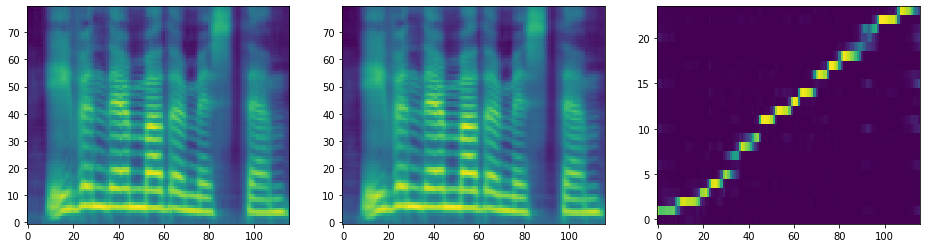

Synthesized audio


Reference audio


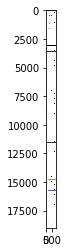

In [29]:
import librosa
from plotting_utils import plot_prosody_dims_to_numpy


script = 'This is temporal style modeling.'
speaker = 'bc2013-w'
emotion = 'neutral'
v = valsets[(speaker, emotion)]
for sample in v:
    print(sample)
    wav_path, script, speaker, sex, emotion, lang = sample
    np_audio, sample_rate, sequence, text_list, alignments, aq, n_synth = synthesize_speech(script, wav_path, speaker, emotion)
    break    